<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>


# <center> Capstone проект №1. Идентификация пользователей по посещенным веб-страницам

# <center> Неделя 7.  Отчет о выполненном проекте

**План 7 недели:**
- цели и задачи проекта, описание исходных и обработанных данных и признаков.
- первичный анализ признаков
- первичный визуальный анализ признаков
- описание предобработки данных
- если создаются признаки, то описание этого процесса
- кросс-валидация, построение кривых валидации и обучения
- оценка модели с описанием выбранной метрики. Опишите простыми словами качество модели, как она может применяться
- выводы: как построенная модель может применяться на практике, какие бизнес-задачи решать. Подведите итог, опишите, что еще можно сделать, а что сделать не удалось.

# Цели и задачи проекта
Описание исходных и обработанных данных и признаков.

В этом соревновании будем решать похожую задачу: алгоритм будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или взломщик (кто-то другой).

Данные собраны с прокси-серверов Университета Блеза Паскаля. "A Tool for Classification of Sequential Data", авторы Giacomo Kahn, Yannick Loiseau и Olivier Raynaud.



## Загрузим тренировочные и тестовые данные

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from matplotlib import pyplot as plt

In [3]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = (r'C:\Users\1\projects\ipynb\coursera\project\week7\works\capstone_user_identification')

In [5]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA,'train_sessions.csv'), 
                           index_col='session_id')

In [6]:
test_df = pd.read_csv(os.path.join(PATH_TO_DATA,'test_sessions.csv'), 
                           index_col='session_id')

Объединим тренировочную и тестовые выборки

In [7]:
train_test_df = pd.concat([train_df, test_df])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [8]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

### Выделим переменные

In [9]:
def create_csr_matrix(data):
    indexes = [0]
    vals = []
    column_indexes = []
    index = 0
    for i in range(0,data.shape[0]):
        for j in range(0, data.shape[1]):
            if data[i,j] != 0:
                column_indexes.append(data[i,j])
                vals.append(1)
                index+=1
        indexes.append(index)
    return csr_matrix((vals, column_indexes, indexes))[:,1:]

train_test_sparse = create_csr_matrix(train_test_df_sites.as_matrix())
X_train_sparse = train_test_sparse[:253561]
X_test_sparse = train_test_sparse[253561:]
y = train_df['target'].as_matrix()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [10]:
enriched_df = pd.DataFrame()

In [11]:
%%time
enriched_df['#uniqe_sites'] = train_test_df_sites.apply(lambda x: len(np.unique(x[:10])), axis=1)

Wall time: 18.2 s


In [12]:
%%time
counter = train_test_df_sites.stack().value_counts()
top_sites = counter[1:50].index
def count_popular(row):
    return len(set(row[:10]) & set(top_sites))

enriched_df['top_sites_visited'] = train_test_df_sites.apply(count_popular, axis=1)

Wall time: 19.2 s


In [13]:
%%time
def get_start_hour(x):
    return datetime.strptime(x[0], "%Y-%m-%d %H:%M:%S").hour

enriched_df['start_hour'] = train_test_df[['time1']].apply(get_start_hour, axis=1)

Wall time: 7.29 s


In [14]:
%%time
def get_start_day_of_week(x):
    return datetime.strptime(x[0], "%Y-%m-%d %H:%M:%S").weekday()
enriched_df['day_of_week'] = train_test_df[['time1']].apply(get_start_day_of_week, axis=1)

Wall time: 7.41 s


In [15]:
%%time
def get_session_timespan(row):
    start_time = row[0];
    end_time = row[0];
    for r in row:
        if r == 0:
            continue
        end_time = r
    start_time = datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")
    end_time = datetime.strptime(end_time, "%Y-%m-%d %H:%M:%S")
    return (end_time - start_time).total_seconds()

enriched_df['ses_timespan'] = train_test_df[['time%d' % i for i in range(1, 11)]].fillna(0).apply(get_session_timespan, axis=1)

Wall time: 16.4 s


In [16]:
%%time
def get_visits_time(row):
    start_time = row[0];
    end_time = row[0];
    res = []
    for r in row:
        if r == 0:
            break
        start_time = end_time
        end_time = r
        s_time = datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")
        e_time = datetime.strptime(end_time, "%Y-%m-%d %H:%M:%S")
        res.append((e_time - s_time).total_seconds())
    while(len(res) < 10):
        res.append(0)
    return res[1],res[2],res[3],res[4],res[5],res[6],res[7],res[8],res[9]

temp = list(zip(*train_test_df[['time%d' % i for i in range(1, 11)]].fillna(0).apply(get_visits_time, axis=1)))
for i, c in enumerate(['time_diff%d' % i for i in range(1, 10)]):
    enriched_df[c] = temp[i]

Wall time: 1min 3s


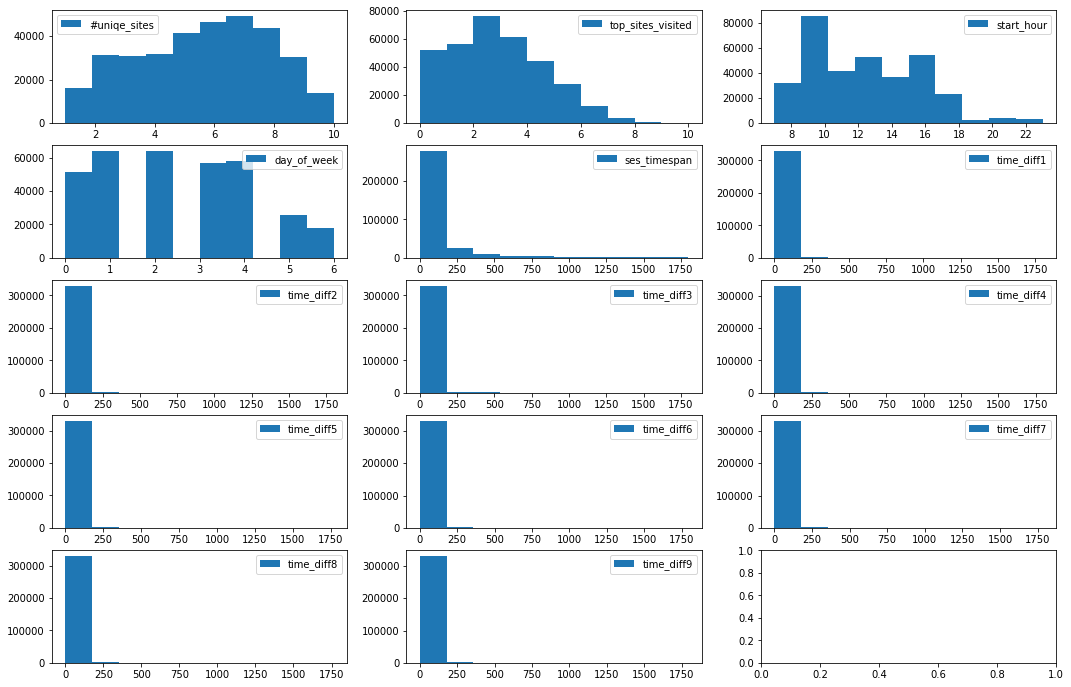

In [17]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 12))

for idx, colname in  enumerate(enriched_df.columns): 
    ax = axes[int(idx/3)][idx%3]
    ax.hist(enriched_df[colname])
    ax.set_label(colname)
    ax.legend([colname])

In [18]:
from scipy.sparse import hstack
enriched_train = enriched_df.as_matrix()[:253561]
enriched_test = enriched_df.as_matrix()[253561:]
enriched_train_sparse = csr_matrix(enriched_train)
enriched_test_sparse = csr_matrix(enriched_test)

X_train_sparse_with_new = csr_matrix(hstack([X_train_sparse, enriched_train_sparse]))
X_test_sparse_with_new = csr_matrix(hstack([X_test_sparse, enriched_test_sparse]))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


### Сохраним полученные результаты в файл

In [19]:
import pickle

In [20]:
with open(os.path.join(PATH_TO_DATA, 
                       'X_train_sparse_vit.pkl'), 'wb') as X_pkl:
                pickle.dump(X_train_sparse_with_new, X_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'X_test_sparse_vit.pkl'), 'wb') as X_pkl:
                pickle.dump(X_test_sparse_with_new, X_pkl, protocol=2)

In [21]:
X_train_sparse_with_new =  pickle.load(open(os.path.join(PATH_TO_DATA, 'X_train_sparse_vit.pkl'), 'rb')) 
X_test_sparse_vit =  pickle.load(open(os.path.join(PATH_TO_DATA, 'X_test_sparse_vit.pkl'), 'rb')) 

In [22]:
X_train_sparse = X_train_sparse_with_new
X_test_sparse = X_test_sparse_vit
y = train_df['target']

# Проанализируем основные признаки

# Визуализируем распределения основных признаков
## Искомые классы

In [34]:
%matplotlib inline
from matplotlib import pyplot as plt

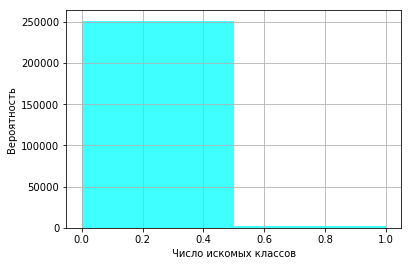

In [36]:
n, bins, patches = plt.hist(y, 2, facecolor='aqua', alpha=0.75)

plt.xlabel('Число искомых классов')
plt.ylabel('Вероятность')
plt.grid(True)

plt.show()

Вывод: искомые классы в обучающей выборке сильно не сбалансированы

## Создание новых признаков

In [29]:
features = ['unique', 'site_max_count', 'com_count', 'fr_count',
            'org_count', 'net_count', 'hour', 'dayofweek', 'month', 'year', 'weekend']

Создание признаков:
- unique - количество уникальных сайтов за сессию
- site_max_count - сайт наиболее часто встречающийся за сессию (если таких несколько, то первый из них)
- com_count - количество сайтов за сессию с расширением .com
- org_count - количество сайтов за сессию с расширением .org
- fr_count - количество сайтов за сессию с расширением .fr
- net_count - количество сайтов за сессию с расширением .net
- hour - время начала сессии (утро, день, вечер, ночь)
- dayofwee - день недели начала сессии
- month - месяц начала сессии
- year - год начала сессии
- weekend - относится ли день начала сессии к выходному дню

In [34]:
from tqdm import tqdm

In [35]:
site_max_count=[]
unique=[]
for k in tqdm(range(len(train_test_df_sites.values))):  
    s = list(train_test_df_sites.values[k])
    t=set(s)
    t-={0}
    unique.append(len(t))
    m = None
    q_max = 0
    for item in set(s):
        q = s.count(item)
        if q > q_max:
            q_max = q
            m = item
    site_max_count.append(m)

100%|██████████| 336358/336358 [00:03<00:00, 103748.21it/s]


In [44]:
t = pd.to_datetime(train_test_df['time1'])
t.iloc[1].hour

11

In [45]:
t = pd.to_datetime(train_test_df['time1'])
hour=[]
for i in tqdm(range(len(t))):
    if ((t.iloc[i].hour >= 6) & (t.iloc[i].hour <= 11)):
        hour.append(1)
    else:
        if ((t.iloc[i].hour >= 12) & (t.iloc[i].hour <= 18)):
            hour.append(2)
        else:
            if ((t.iloc[i].hour >= 19) & (t.iloc[i].hour <= 23)):
                hour.append(3)
            else:
                hour.append(4)
                    

100%|██████████| 336358/336358 [00:10<00:00, 31669.14it/s]


In [46]:
dayofweek=[]
month=[]
year=[]
for i in tqdm(range(len(t))):
    dayofweek.append(t.iloc[i].dayofweek)
    month.append(t.iloc[i].month)
    year.append(t.iloc[i].year)


100%|██████████| 336358/336358 [00:10<00:00, 32503.71it/s]


In [47]:
weekend=[]
for i in dayofweek:
    if i >5:
        weekend.append(1)
    else:
        weekend.append(0)

In [49]:
with open(os.path.join(PATH_TO_DATA, 'site_dic.pkl'), 'rb') as s:
        d = pickle.load(s)

In [50]:
tts = train_test_df_sites.values
d1 = {v:k for k, v in d.items()}
d1[0]=0

In [51]:
r = []  
for k in tqdm(range(len(tts))):  
    for i in range(10):
        if d1[tts[k][i]] != 0:
              r.append(d1[tts[k][i]].split('.')[-1])
        else:
              r.append(0)   

100%|██████████| 336358/336358 [00:04<00:00, 76099.10it/s]


In [52]:
r = np.array(r).reshape((336358, 10))

In [53]:
com_count = []
fr_count = []
org_count = []
net_count = []
for i in tqdm(range(len(r))):
    com_count.append(list(r[i]).count('com'))
    fr_count.append(list(r[i]).count('fr'))
    org_count.append(list(r[i]).count('org'))
    net_count.append(list(r[i]).count('net'))


100%|██████████| 336358/336358 [00:04<00:00, 78609.39it/s]


In [54]:
train_test_df_sites['com_count']=com_count
train_test_df_sites['fr_count']=fr_count
train_test_df_sites['org_count']=org_count
train_test_df_sites['net_count']=net_count
train_test_df_sites['unique']=unique
train_test_df_sites['site_max_count']=site_max_count
train_test_df_sites['hour']=hour
train_test_df_sites['dayofweek']=dayofweek
train_test_df_sites['month']=month
train_test_df_sites['year']=year
train_test_df_sites['weekend']=weekend


In [55]:
def ftr_unique_sites(row):
    sites=row[['site1', 'site2', 'site3', 'site4','site5', 'site6','site7', 'site8','site9', 'site10']]
    return len(np.unique(sites))

def ftr_session_timespan(row):
    time_start= datetime.strptime(row['time1'], '%Y-%m-%d %H:%M:%S')
    time_end=row['time10']
    if (str(time_end)=='nan'):
        res=30*60
    else:  
        time_end= datetime.strptime(row['time10'], '%Y-%m-%d %H:%M:%S')
        res=(time_end-time_start).total_seconds()
    return int(res)

def ftr_from_time(row, time1, time10):
    time_start=row[time10]
    if (str(time_start)=='nan'):
        res=30*60
    else:  
        time_start= datetime.strptime(row[time1], '%Y-%m-%d %H:%M:%S')
        
    time_end=row[time10]
    if (str(time_end)=='nan'):
        res=30*60
    else:  
        time_end= datetime.strptime(row[time10], '%Y-%m-%d %H:%M:%S')
        res=(time_end-time_start).total_seconds()
    return int(res)

def ftr_session_timespan(row):
    return ftr_from_time(row, 'time1', 'time10')

def ftr_mean_site_session(row):
    lst = []
    for i in range(1, 10):
        n = ftr_from_time(row, 'time' + str(i), 'time'  + str(i+1))
        if(n!=0):
            lst.append(n)
    if(len(lst)==0):
        lst.append(0)
    return np.mean(lst)

In [56]:
def gen_features(df):
    newdf=pd.DataFrame(index=df.index)
    newdf['session_timespan']=df.apply(ftr_session_timespan, axis=1)
    newdf['unique_sites']=df.apply(ftr_unique_sites, axis=1)
    newdf['mean_site_sessio']=df.apply(ftr_mean_site_session, axis=1) 
    return newdf

In [57]:
additional=gen_features(train_df)


In [58]:
q95 = additional.session_timespan.quantile(.95)
q05 = additional.session_timespan.quantile(.05)
print (q05,q95)
additional['session_timespan_filtered'] = additional['session_timespan'].apply(lambda x: filter_perc(q95, q05, x))
additional = additional.fillna(0)

2.0 1800.0


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


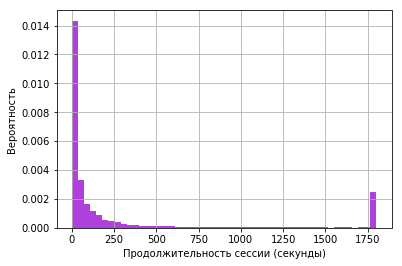

In [59]:
n, bins, patches = plt.hist(additional['session_timespan_filtered'], 50, normed=1, facecolor='darkviolet', alpha=0.75)

plt.xlabel('Продолжительность сессии (секунды)')
plt.ylabel('Вероятность')
plt.grid(True)

plt.show()


Вывод: большиство сессий имеют продолжительность меньше 1.5 минут.

##  Распределение числа уникальных сайтов в сессии

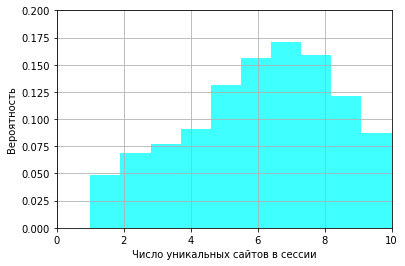

In [60]:
n, bins, patches = plt.hist(additional['unique_sites'], 10, normed=1, facecolor='aqua', alpha=0.75)

plt.xlabel('Число уникальных сайтов в сессии')
plt.ylabel('Вероятность')
plt.axis([0, 10, 0, 0.2])
plt.grid(True)

plt.show()

Вывод: в среднем число уникальных сайтов в сессии из 10 сайтов составляет 6-7 штук.

## Распределение часа начала сессии

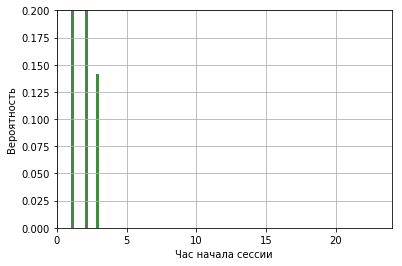

In [65]:
train_test_df_sites['hour'] = train_test_df_sites['hour'].apply(lambda x: int(x))
plt.hist(train_test_df_sites['hour'], 10, normed=1, facecolor='darkgreen', alpha=0.75)

plt.xlabel('Час начала сессии')
plt.ylabel('Вероятность')
plt.axis([0, 24, 0, 0.2])
plt.grid(True)

plt.show()

Выводы:
- В данной выборке отсуствуют сессии с временем начала с 23 до 7 часов утра
- Чаще всего пользователи выходят в интернет утром с 7 до 9, в обед с 13 до 14 и вечером с 15 до 18

## Распределение дня начала сессии

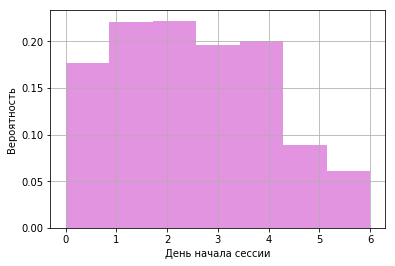

In [66]:
train_test_df_sites['day_of_week'] = train_test_df_sites['dayofweek'].apply(lambda x: int(x))
plt.hist(train_test_df_sites['day_of_week'], 7, normed=1, facecolor='orchid', alpha=0.75)
plt.xlabel('День начала сессии')
plt.ylabel('Вероятность')
plt.grid(True)
plt.show()

Вывод: люди большую часть времени проводят в интернете по будням, кол-во сессий в субботу и воскресение значительно меньше.

## Сезон

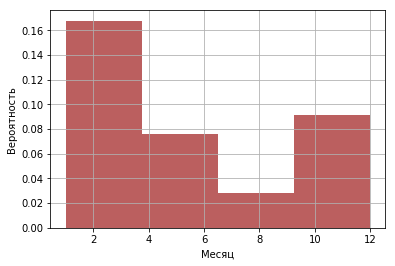

In [67]:
train_test_df_sites['month'] = train_test_df_sites['month'].apply(lambda x: int(x))
plt.hist(train_test_df_sites['month'], 4, normed=1, facecolor='brown', alpha=0.75)
plt.xlabel('Месяц')
plt.ylabel('Вероятность')
plt.grid(True)
plt.show()

Вывод:кол-во сессий осенью значительно меньше, чем в остальные сезоны.

## Обучение

Реализуем функции визуализации AUC кривых и записи результатов в файл в формате kaggle.

In [68]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [69]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

Подготовим кросс-валидатор, и попробуем с помощью GridSearchCV и вычислить оптимальный классификатор и его параметры

In [70]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

Попробуем применить различные алгоритмы классификации с набором параметров по сетке с помощью GridSearchCV
- LogisticRegression
- Linear SVM
- SGDClassifier
- RandomForestClassifier

In [71]:
def search_cv_predict_write(estimator, params_grid, X_train, y_train, X_test, filename, cv=skf):
    grid_searcher = GridSearchCV(estimator, params_grid, scoring = 'roc_auc',  n_jobs = -1, cv=skf)
    grid_searcher.fit(X_train, y_train)

    print(grid_searcher.best_score_)
    print (grid_searcher.best_params_)
    
    test_pred_proba = np.array([*map(lambda x: x[1], grid_searcher.best_estimator_.predict_proba(X_test))])
    write_to_submission_file(test_pred_proba, filename)
    return grid_searcher

##  LogisticRegression с LogisticRegressionCV

In [72]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [73]:
%%time
estimator = LogisticRegressionCV(random_state=17, n_jobs=-1, cv = skf, Cs = np.linspace(1, 11, 25), scoring = 'roc_auc')
estimator.fit(X_train_sparse_with_new, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Wall time: 55.4 s


In [89]:
estimator.scores_

{1: array([[0.81613038, 0.8887424 , 0.91983745, 0.93101677, 0.94083036,
         0.94876492, 0.95313384, 0.95563579, 0.95846658, 0.95881334,
         0.95921975, 0.96155252, 0.96176388, 0.96348284, 0.96415436,
         0.96533608, 0.96610313, 0.96599756, 0.96652324, 0.96655632],
        [0.80703082, 0.85612434, 0.8949392 , 0.92337362, 0.933124  ,
         0.94381547, 0.94655931, 0.95137325, 0.95142274, 0.95705444,
         0.95561578, 0.95854824, 0.95798509, 0.96255078, 0.95992501,
         0.96158347, 0.95601311, 0.96310167, 0.96350796, 0.96523744],
        [0.82353792, 0.89607453, 0.9215082 , 0.93653167, 0.94679926,
         0.94939295, 0.95185129, 0.95663978, 0.95862074, 0.96030062,
         0.96267413, 0.96440956, 0.96405018, 0.96531344, 0.96553942,
         0.96885618, 0.97007274, 0.97145075, 0.97206405, 0.97200168]])}

In [79]:
test_pred = estimator.predict_proba(X_test_sparse_with_new)
write_to_submission_file(test_pred[:,1], os.path.join(PATH_TO_DATA, 'submission_LogisticRegressionCV.csv'))

## LogisticRegression с GridSearchCV

In [75]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [76]:
logit = LogisticRegression(C = 55, random_state = 17)
logit_params2 = {'C': np.linspace(1, 5, 25)}

In [77]:
%%time
grid_searcher = search_cv_predict_write(logit, logit_params2, X_train_sparse_with_new, y, X_test_sparse_with_new, 'submission-logistic.txt')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.8228691669669761
{'C': 2.0}
Wall time: 3min 44s


##  SGDClassifier

In [80]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [81]:
sgd_logit = SGDClassifier( loss='log', random_state=17, n_jobs=-1, penalty='l1')
sgd_param_grid = {
    'n_iter':[ 100, 200, 300 ],
    'alpha' : [0.0001, 0.00001],
    'penalty' : ['l1', 'l2'],
    'loss' : ['log']
}

In [82]:
%%time
sgd_grid_searcher = search_cv_predict_write(sgd_logit, sgd_param_grid, X_train_sparse_with_new, y, X_test_sparse_with_new, 'submission-sgd.txt')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.894139800134458
{'alpha': 1e-05, 'loss': 'log', 'n_iter': 300, 'penalty': 'l1'}
Wall time: 1min 28s


## RandomForestClassifier

In [83]:
from sklearn.ensemble import RandomForestClassifier

In [84]:
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
forest_param_grid = { 
    'n_estimators': [100],
    'max_features': ['auto']
}

In [85]:
%%time
forest_grid_searcher = search_cv_predict_write(forest, forest_param_grid, X_train_sparse_with_new, y, X_test_sparse_with_new, 'submission-forest.txt')

0.9688784961289091
{'max_features': 'auto', 'n_estimators': 100}
Wall time: 3min 33s


In [90]:
test_pred2 = forest_grid_searcher .predict_proba(X_test_sparse_with_new)
write_to_submission_file(test_pred2[:,1], os.path.join(PATH_TO_DATA, 'submission_Forest.csv'))

## sklearn.ensemble.BaggingClassifier

In [86]:
from sklearn.ensemble import BaggingClassifier

In [87]:
logit = LogisticRegression(C = 1.62, random_state = 17)
bagging = BaggingClassifier(logit, n_jobs = -1)
bagging_params = {
                    'n_estimators': [10],
                 }

In [88]:
%%time
svm_best_estimator = search_cv_predict_write(bagging, bagging_params, X_train_sparse_with_new, y, X_test_sparse_with_new, 'submission-bagging.txt')


0.8341315751556498
{'n_estimators': 10}
Wall time: 2min 18s


## Лучшая модель

Лучший результат показала модель, которая была натренирована с помощью LogisticRegressionCV. Она показала результат __0.93__ roc auc

# Выводы

 - Лучшие результаты показала модель построенная с помощью Linear Regression CV классификатора. Она определяет, что пользователь не тот за кого себя выдает с площадью под кривой ROC AUC 93%.
 - Данный результат кажется отличным, но это связано с несбалансированностью классов. Константный метод, получает результат в 0.82.


# Методы улучшения

- добавить новые признаки
- использовать бустинг, нейронки
